In [164]:
from elasticsearch import Elasticsearch, helpers
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
plt.style.use('default')

# Outlier Detection by Example

Outlier detection has been available in machine learning since 7.2 - what follow is a demonstration about how to create outlier detection analyses and how to analyze the results.

For the sake of demonstration, we'll be using an artifical two-dimensional dataset that I've created using `numpy` and `scikit-learn`.

In [294]:
n_dim = 2
n_samples = 2500
data = make_blobs(centers=[[-1, -1], [3, 1]],
                  cluster_std=[1.25, 0.5],
                  n_samples=n_samples,
                  n_features=n_dim)[0]

# add outliers from a uniform distribution [-6,6]
n_outliers = 99
rng = np.random.RandomState(19)
outliers = rng.uniform(low=-5, high=5, size=(n_outliers, n_dim))

# add the outliers back into the data
data = np.concatenate([data, outliers], axis=0)

This dataset contains 2500 points normally-distributed around two main clusters centers at `(-1, -1)` and `(3, 1)`. Scikit-learn's `make_blobs` method allows us to control the standard deviations of each cluster, which I've set to `1.25` and `0.5`, respctively. This allows us to see how outlier detection functions on data with differing densities.

After making the data clusters, we introduce 99 new points, with `x` and `y` locations randomly sampled from a uniform distribution. Some of these points will fall well outside the clusters we created and should be deemed outliers; others will lie within the clusters and appear as normal points.

In the visualization below the added points are marked with an orange `X` and the original points are marked as blue dots.

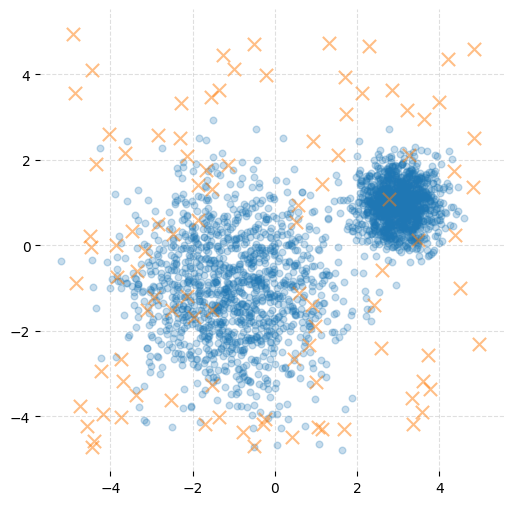

In [350]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='white')
plt.scatter(data[:2500, 0], data[:2500, 1], alpha=0.25, cmap='cool', marker='.', s=91)
plt.scatter(data[2500:, 0], data[2500:, 1], alpha=0.5, cmap='cool', marker='x', s=91)
plt.clim(0,1)
plt.grid(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(color='gray', alpha=0.25, linestyle='dashed')
ax.xaxis.grid(color='gray', alpha=0.25, linestyle='dashed')

ax.set_axisbelow(True)

# Elasticsearch

## Index Data

Let's use the [elasticsearch python client](https://github.com/elastic/elasticsearch-py) to ingest this data into elasticsearch. This step requires a local elasticsearch cluster running on port `9200`.

In [296]:
host = "http://localhost:9200"
es = Elasticsearch(host)

# take our iteratble, data, and build a generator to pass to elasticsearch-py's helper function
def gen_blobs():
    for point in data:
        yield {
            "_index": "blobs",
            "_type": "document",
            "x": point[0],
            "y": point[1]
        }

helpers.bulk(es, gen_blobs())

(2599, [])

## Create Outlier Analysis

Now we will send a request to elasticsearch to create our outlier analysis. The configuration for the analysis requires the following:

* a `source` index. This is the index `blobs` that we just ingested. Optionally, we can add a query to our index to just run outlier detection on a subset of the data.
* a `dest` index. The data from `source` will be reindexed into the destination index and the outlier detection analysis will add the results directly to this index.
* the `analysis` configuration. Here we're specifying that we want to run `outlier-detection`. Other options include `regression` and `classification`.
* an `analyzed_fields` object that instructs the analysis which fields to include and exclude.

In [297]:
api = "/_ml/data_frame/analytics/blobs-outlier-detection"
config = {
    "source": {
        "index": "blobs",
        "query": {"match_all": {}}
    },
    "dest": {
        "index": "blobs-outliers"
    },
    "analysis": {
        "outlier_detection": {}
    },
    "analyzed_fields": {
        "includes": ["x", "y"],
        "excludes": []
    }
}

print(requests.put(host+api, json=config).json())

{'id': 'blobs-outlier-detection', 'source': {'index': ['blobs'], 'query': {'match_all': {}}}, 'dest': {'index': 'blobs-outliers', 'results_field': 'ml'}, 'analysis': {'outlier_detection': {'compute_feature_influence': True, 'outlier_fraction': 0.05, 'standardization_enabled': True}}, 'analyzed_fields': {'includes': ['x', 'y'], 'excludes': []}, 'model_memory_limit': '1gb', 'create_time': 1575655434830, 'version': '7.6.0', 'allow_lazy_start': False}


## Start Analysis

In [298]:
api = "/_ml/data_frame/analytics/blobs-outlier-detection/_start"
print(requests.post(host+api).json())

{'acknowledged': True}


The analysis should complete in less that a minute.

# Analyze Results

Now that our analysis is finished, let's view the results. We'll pull the data back into python using the `helpers.scan()` method from the elasticsearch python client. We see that our new `blobs-outliers` index contains information output by the outlier detection analysis:

* `ml.outlier_score`: the overall outlier score of the data point representated as a value between `0` and `1`.
* `ml.feature_influence.x`: the influence that the field `x` had on the outlier score representated as a value between `0` and `1`.
* `ml.feature_influence.y`: the influence that the field `y` had on the outlier score representated as a value between `0` and `1`.

For more information about how outlier scores and feature influence are calculated, please see the [Outlier Detection Documentation](https://www.elastic.co/guide/en/elastic-stack-overview/current/dfa-outlier-detection.html). And if you're especially curious about how our modeling compares to other outlier detection models out there, have a look at this recent blog post where we [benchmarked our outlier detection](https://www.elastic.co/blog/benchmarking-outlier-detection-in-elastic-machine-learning) against many other algorithms.

In [351]:
es_data = []
for blob in  helpers.scan(es, index='blobs-outliers'):
    obj = [
        blob['_source']['x'], 
        blob['_source']['y'], 
        blob['_source']['ml']['outlier_score'], 
        blob['_source']['ml'].get('feature_influence.x', 0),
        blob['_source']['ml'].get('feature_influence.y', 0)
    ]
    es_data.append(obj)

es_data = np.asarray(es_data)

Now, we can view our original data again, this time coloring the points based on their outlier score. Here, blue values correspond to low scores, and pink values correspond to high scores.

We can see how our cluster densities affect the scoring. There appears to be a marked increase in outlier scores for points just outside the right cluster. Compare this to the less clearly defined border of the left cluster; we can see that the increase in scores is less drastic for points spreading away from the cluster.

Also note the high scores for points that sit on the edges of the figure - these points lie far away from both clusters.

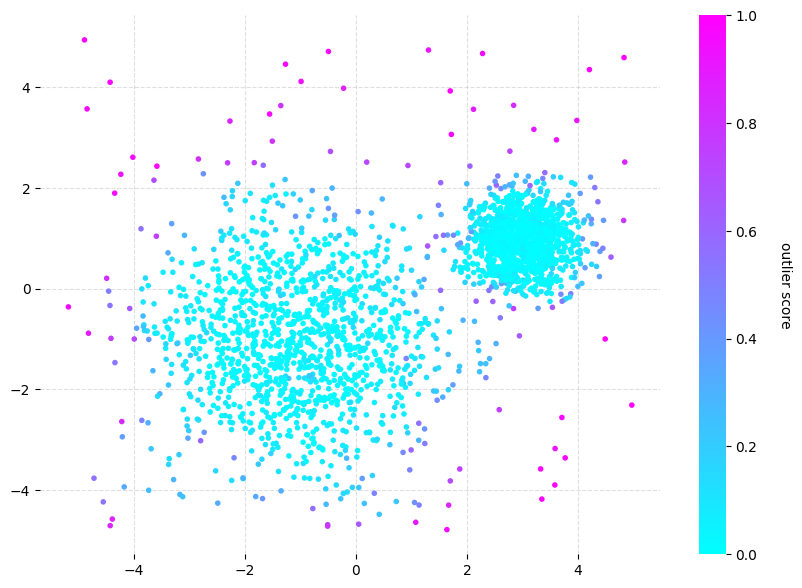

In [356]:
fig, ax = plt.subplots(figsize=(10,7), facecolor='white')
plt.scatter(es_data[:, 0], es_data[:, 1], c=es_data[:, 2], cmap='cool', marker='.')
plt.clim(0,1)
plt.grid(True)
cb = plt.colorbar()
cb.outline.set_visible(False)
cb.ax.get_yaxis().labelpad = 25
cb.ax.set_ylabel('outlier score', rotation=270)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(color='gray', alpha=0.25, linestyle='dashed')
ax.xaxis.grid(color='gray', alpha=0.25, linestyle='dashed')

ax.set_axisbelow(True)

Now, let's overlay feature influence on this visualization. Below, we see the same points with ellipses whose width and height correspond to the influence of `x` and `y`, respectively, on that points outlier score.

Note how the ellipses in the upper left of our space are almost circular - they are outlier because the sit far away from the clusters in both the `x` and `y` dimensions. Ellipses in the upper right (above the right cluster) are so narrow that they appear almost as lines - this is because their `x` values fall well within the range of `x` values for the right cluster, while their `y` values abnormally exceed the typical `y` values of points in the right cluster.

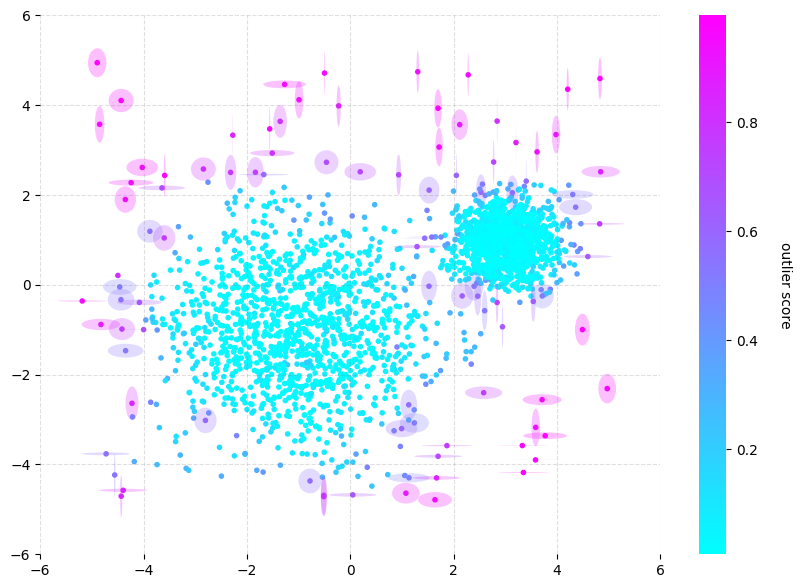

In [358]:
from matplotlib.patches import Ellipse

cmap = matplotlib.cm.get_cmap('cool')
fig, ax = plt.subplots(figsize=(10,7), facecolor='white')
ell = [[Ellipse(xy = (blob[0], blob[1]), width=blob[3], height=blob[4]), blob[2]] for blob in es_data if blob[2]>0.5]

for e in ell:
    ax.add_artist(e[0])
    e[0].set_clip_box(ax.bbox)
    e[0].set_alpha(0.25)
    e[0].set_facecolor(cmap(e[1]))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(color='gray', alpha=0.25, linestyle='dashed')
ax.xaxis.grid(color='gray', alpha=0.25, linestyle='dashed')

plt.scatter(es_data[:, 0], es_data[:, 1], c=es_data[:, 2], cmap='cool', marker='.')
cb = plt.colorbar()
cb.outline.set_visible(False)
cb.ax.get_yaxis().labelpad = 25
cb.ax.set_ylabel('outlier score', rotation=270)
    
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6);